<a href="https://colab.research.google.com/github/mawebi/charging-strategy/blob/main/ideal_charging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What
With this tool, you can calculate ideal trips for travelling with an electric car.

The tool calculates the best effective speed, which includes the charging stops for different car models.

# How to
If you change any parameter (e.g. settings or car definitions), press Ctrl+F9 or choose "Execute all" from Menu.

You will find calculations as table and different comparison graphs below.

# Data source
As input date, the Youtube Channel Battery Life was used. As consumption only values for ID.4|TelsaY were used (for ID3/5,Enyaq,Ioniq5 the data from ID.4 was used, because of missing data).
Charging curves are all recorded by Battery Life for the specific model.

In [354]:
#@title Source code definition
# Import required packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil
from scipy.optimize import curve_fit

# Extra time [min] used per charging stop (driving to the charger, plugin cable, ...)
extra_time_default = 8
# Start charging at percentage
start_at_percent_default = 10

# fitting functions
#def quadratic(x, a, b, c):
#  return a*x*x + b*x + c
def quadratic(x, a, b, c):
  return a*x*x + b*x + c
def cubic(x, a, b, c):
  return a*x*x*x + b*x*x + c*x
def poly(x, a, b, c, d, e):
  return a*(x**4) + b*(x**3) + c*x*x + d*x + e


class Car:
  def __init__(self, name, consumption_data, charging_data, capacity, start_at_percent=start_at_percent_default, extra_time=extra_time_default, speed_min=80, speed_max=200, distance_min=50, distance_max=300):
    self.name = name
    self.extra_time = extra_time
    self.capacity = capacity
    self.start_at_percent = start_at_percent
    self.consumption_x, self.consumption_y = zip(*consumption_data)
    self.charging_data = self._convertChargingCurve(charging_data, start_at_percent, capacity)    
    self.consumption_fitting_pars, _ = curve_fit(quadratic, self.consumption_x, self.consumption_y, bounds=(0,np.inf))
    x = np.array(self.charging_data)
    y = np.arange(start=1, stop=len(self.charging_data)+1, step=1)
    self.charging_fitting_pars, _ = curve_fit(cubic, x, y)  #bounds=([-np.inf,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,0]
    self.v = np.arange(start=speed_min, stop=speed_max, step=1)
    self.s = np.arange(start=distance_min, stop=distance_max, step=10)
  
  def _convertChargingCurve(self,charging_data, start_at, capacity, cut_slow_end=True):
    """Convert from percent array to kWh, truncate start"""
    # [...,87, 89, 89, 90] -> [...,87, 89] the curve ends when the percentage does not change in one minute
    if cut_slow_end:
      for idx, x in enumerate(charging_data):
        if idx > 0:
          if charging_data[idx-1] == charging_data[idx]:
            charging_data = charging_data[:idx]
            break
    
    for idx, x in enumerate(charging_data):
      if (start_at <= x):
        return [((c-charging_data[idx])*capacity/100.0) for c in charging_data[idx+1:]]

  def consumption(self, v):
    """Consumption [kWh] as function of speed [km/h]."""
    return quadratic(v, *self.consumption_fitting_pars)/1000.0

  def charging_time(self, energy_charged):
    """Charging time [min] as a function of charged energy [kWh]"""
    return cubic(energy_charged, *self.charging_fitting_pars)
  
  def effective_velocity(self, v, s):
    """"The effective speed including charging time and extra time per charging stop.
        The function depends on the driven speed v[km/h] and stage distance s [km]"""
    # time to drive distance s
    t1 = (s / v)
    # energy neccessary to drive distance s
    E = self.consumption(v) * s
    # time to charge E
    t2 = (self.charging_time(E)+ self.extra_time)/60.0

    if ((((E / self.capacity) * 100)+self.start_at_percent)>100):
      return np.nan 
    else:
      return s/(t1+t2)

  def best_speed_with_fixed_distance(self, s):
    """Calculate the best driven speed [km/h] to get the best effective speed including charging times. The function depends on a fixed stage distance s [km]."""
    return self.v[np.nanargmax([self.effective_velocity(v, s) for v in self.v])]

  @property
  def best_distance(self):
    """Calculates the distance with the highest effective speed."""
    best_overall_distance = self.s[np.nanargmax([self.effective_velocity(self.best_speed_with_fixed_distance(x),x) for x in self.s])]
    return best_overall_distance

  @property
  def best_velocity(self):
    """Calculates the best velocity based on the best distance"""
    best_overall_velocity = self.best_speed_with_fixed_distance(self.best_distance)
    return best_overall_velocity
  
  def __str__(self):
    return self.name

  def stats(self, fixed_distance=0, use_best_distance=True):
    if use_best_distance:
      fixed_distance = self.best_distance
    s = fixed_distance
    v = self.best_speed_with_fixed_distance(s)
    E = self.consumption(v) * s
    t = self.charging_time(E)
    p = ((E / self.capacity) * 100)+self.start_at_percent
    t_drive = (s / v) *60.0
    t_total = t + t_drive + self.extra_time
    veff = s/((t_total)/60.0)
    return {
        "name": self.name,
        "capacity": self.capacity,
        "veff": veff,        
        "distance": s,
        "v": v,        
        "charging_from": self.start_at_percent,
        "charging_to": round(p),
        "charging_energy": E,
        "driving_time": round(t_drive),    
        "charging_time": round(t),        
        "extra_time": self.extra_time,
        "total_time" : round(t_total),
    }
  
  # plotting
  def plot_fixed_distance(self, s, fig=None):
    if fig == None:
      fig = plt.figure(figsize=(7, 5))
    plt.plot(self.v, [self.effective_velocity(v, s) for v in self.v], label=self.name + " s=%3dkm"%s)

  def plot_charging_curve(self, stop_at_percent=80, fig=None):
    p = (stop_at_percent - self.start_at_percent) / 100.0
    E = np.arange(start=0, stop=floor(p*self.capacity), step=1)
    #t = [self.charging_time(x)+self.extra_time for x in E]
    t = [self.charging_time(x) for x in E]
    avg_E = E/( (t+np.double(self.extra_time)) /np.double(60.0) )
    #t = [self.charging_time(x) for x in E]
    if fig == None:
      fig = plt.figure(figsize=(9, 7))
    plt.plot(t, avg_E, label=self.name)
    #plt.plot(t, avg_E, label=self.name + " (extra_time=%2dmin)"%self.extra_time)


  def plot_charging_time_curve(self):
    x = np.array(self.charging_data)
    y = np.arange(start=1, stop=len(self.charging_data)+1, step=1)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlabel('Energy to charge [kWh]', labelpad=10)
    ax.set_ylabel('Charging time [min]', labelpad=10)    
    plt.scatter(x, y, marker="+", color="red", label=self.name)
    plt.plot(x, cubic(x, *self.charging_fitting_pars),linestyle='--', linewidth=2, color='black', label='fit: %5.4f*x³ + %5.4fx² + %5.3fx' % tuple(self.charging_fitting_pars))
    plt.legend()
    plt.show()

  def plot_consumption_curve(self):
    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(7, 5))
    # Add axes object to our figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])
    # Plot the noisy exponential data
    plt.scatter(self.consumption_x, self.consumption_y, color='red', s=80, marker="o", label=self.name)
    x = np.arange(start=0, stop=200, step=2)
    plt.plot(x, quadratic(x, *self.consumption_fitting_pars), linestyle='--', linewidth=2, color='black', label='fit: %5.4f*x² + %5.3fx + %5.2f' % tuple(self.consumption_fitting_pars))
    # Add the x and y-axis labels
    ax.set_xlabel('Velocity [km/h]', labelpad=10)
    ax.set_ylabel('Consumption [Wh/km]', labelpad=10)
    plt.legend()
    plt.show()

# Settings and car definitions

In [355]:
#@title User input forms { run: "auto" }
#@markdown ## Settings
#@markdown Define the extra time you need per charging stop (drive to charger, plugin, authenticate, ...)
extra_time_per_stop = 10 #@param {type:"slider", min:0, max:20, step:1}
#@markdown Start charging at percentage (SoC) in %:
start_charging_at = 10 #@param {type:"slider", min:10, max:40, step:5}
#@markdown The minimal and maximal speeds used for calculations. This parameter also defines the x-axis of the plots:
minimal_speed = 80 #@param {type:"slider", min:60, max:250, step:10}
maximal_speed = 180 #@param {type:"slider", min:60, max:250, step:10}

#@markdown ---

cars = []
compare_cars = []
#@markdown ## Car definitions
#@markdown Instruction: Consumption as function of speed is an array in (km/h,Wh); battery capacity in kWh and charging curve is SoC recorded accurate every minute.
#@markdown 
#@markdown Data sources: Youtube Channel Battery Life
#@markdown - <sub><sup>https://docs.google.com/spreadsheets/d/1cDlLxhUQsuCXLG0h_SnDPX8BIy0VpI32jDNrInWsMrA
#@markdown - <sub><sup>https://docs.google.com/spreadsheets/d/1jK1kQxkjBP1BIzoGvfDdOQ80w-5dvzO_c3qRCVtGZoQ
#@markdown - <sub><sup>https://www.youtube.com/watch?v=Y4ZzUNs3mCg&list=PLwCzgH6q6jksw-5kii9PBDvB1Lqqw7IS6&index=25

#@markdown ## Car 1
add_to_comparison_1 = False #@param ["True", "False"] {type:"raw"}
name_1 = 'ID.3 45kWh' #@param {type:"string"}
capacity_1 = 45.0 #@param {type:"number"}
consumption_1 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_1 = [6,10,13,17,21,25,28,32,35,38,41,44,47,49,52,54,56,59,61,63,65,67,69,71,73,74,76,78,79,81,82,84,85,87,89,90,92,93,94,95,97,98,99] #@param {type:"raw"}
c = Car(name_1, consumption_1, charging_curve_1, capacity_1, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_1:
  compare_cars.append(c)
  
#@markdown ---

#@markdown ## Car 2
add_to_comparison_2 = False #@param ["True", "False"] {type:"raw"}
name_2 = 'ID.3 58kWh Software 3.0' #@param {type:"string"}
capacity_2 = 58.0 #@param {type:"number"}
consumption_2 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_2 =  [4,8,12,15,19,23,26,29,32,35,38,40,42,44,46,48,50,52,54,56,58,60,62,63,65,66,68,69,70,72,73,74,76,77,78,80,81,82,84,85,86,87,88,88,89,90,91,91,92,93,93,94,95,95,96,97,97,98] #@param {type:"raw"}
c = Car(name_2, consumption_2, charging_curve_2, capacity_2, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_2:
  compare_cars.append(c)
#@markdown ---

#@markdown ## Car 3
add_to_comparison_3 = False #@param ["True", "False"] {type:"raw"}
name_3 = 'ID.3 77 kWh Software 2.x' #@param {type:"string"}
capacity_3 = 77.0 #@param {type:"number"}
consumption_3 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_3 = [3,5,8,10,12,15,17,19,24,27,31,34,35,38,40,42,45,47,49,51,53,55,57,59,61,62,64,65,67,68,70,71,73,74,75,77,78,79,81,82,83,84,85,86,87,88,89,90,91,91,92,93,93,94,95,95,96,97,97,98,98,99,99] #@param {type:"raw"}
c = Car(name_3, consumption_3, charging_curve_3, capacity_3, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_3:
  compare_cars.append(c)

#@markdown ---

#@markdown ## Car 4
add_to_comparison_4 = True #@param ["True", "False"] {type:"raw"}
name_4 = 'ID.5 RWD 77kWh Software 3.1' #@param {type:"string"}
capacity_4 = 77.0 #@param {type:"number"}
consumption_4 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_4 = [4,6,10,13,16,19,22,25,28,31,34,37,40,43,45,48,51,53,56,59,61,64,66,68,71,73,75,77,79,80,82,83,84,85,86,87,87,88,88,89,90,90,91,92,92,93,93,94] #@param {type:"raw"}
c = Car(name_4, consumption_4, charging_curve_4, capacity_4, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_4:
  compare_cars.append(c)

#@markdown ---

#@markdown ## Car 5
add_to_comparison_5 = True #@param ["True", "False"] {type:"raw"}
name_5 = 'Enyaq Coupe RS 77kWh Software 3.0' #@param {type:"string"}
capacity_5 = 77.0 #@param {type:"number"}
consumption_5 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_5 = [7,11,15,19,23,26,29,32,35,38,40,42,44,46,48,50,52,54,56,57,59,61,62,64,65,66,68,69,71,72,73,75,76,77,79,80,81,83,84,85,86,87,88,89,89,90] #@param {type:"raw"}
c = Car(name_5, consumption_5, charging_curve_5, capacity_5, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_5:
  compare_cars.append(c)

#@markdown ---

#@markdown ## Car 6
add_to_comparison_6 = True #@param ["True", "False"] {type:"raw"}
name_6 = 'Ioniq 5' #@param {type:"string"}
capacity_6 = 72.6 #@param {type:"number"}
consumption_6 = [( 86.7, 137),(107.2, 170),(116.9, 205)] #@param {type:"raw"}
charging_curve_6 = [7,9,12,16,20,24,29,34,38,43,48,51,54,57,61,64,68,71,74,77,79,82,84,86,87,88,90,91,91,92,93,94,94,95,95,96,96,97,98,98,99,99] #@param {type:"raw"}
c = Car(name_6, consumption_6, charging_curve_6, capacity_6, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_6:
  compare_cars.append(c)

#@markdown ---

#@markdown ## Car 7
add_to_comparison_7 = True #@param ["True", "False"] {type:"raw"}
name_7 = 'Tesla Model Y' #@param {type:"string"}
capacity_7 = 77.0 #@param {type:"number"}
consumption_7 = [( 85.7,123),(100.9,155),(115.2, 187)] #@param {type:"raw"}
charging_curve_7 = [9,13,16,20,23,27,31,33,35,38,40,42,44,46,48,50,52,54,56,57,59,61,62,64,65,67,68,70,71,72,73,75,76,77,78,80,81,82,83,83,85,86,87,88,88,89,90] #@param {type:"raw"}
c = Car(name_7, consumption_7, charging_curve_7, capacity_7, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_7:
  compare_cars.append(c)

#@markdown ---

#@markdown ## Car 8
add_to_comparison_8 = False #@param ["True", "False"] {type:"raw"}
name_8 = 'Fiat 500e' #@param {type:"string"}
capacity_8 = 42.0 #@param {type:"number"}
consumption_8 = [(84.8,121),(105.7,156),(116.9,192)] #@param {type:"raw"}
charging_curve_8 = [10,13,17,21,25,28,32,35,38,41,44,47,50,53,56,59,61,63,66,69,71,73,75,77,79,81,83,85,85,86,87,87,87,88,89,89,90,90,90,91,92,92,92,93,94,94,95,95,96,96,97,97,98,98,99,99] #@param {type:"raw"}
c = Car(name_8, consumption_8, charging_curve_8, capacity_8, start_at_percent=start_charging_at, extra_time=extra_time_per_stop, speed_min=minimal_speed, speed_max=maximal_speed)
cars.append(c)
if add_to_comparison_8:
  compare_cars.append(c)

#@markdown ---

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Results table

In [356]:
from pandas.core.frame import DataFrame
from google.colab import data_table

#@title Best stage stats for fastest travel { run: "auto" }
car_number = "All cars" #@param ["All cars", "Comparsion cars", "Car 1", "Car 2", "Car 3", "Car 4", "Car 5", "Car 6"]
#@markdown Calculate the best distance per car and use always best distance (ignore fixed distance parameter)
use_best_distance = True #@param ["True", "False"] {type:"raw"}
#@markdown Calculate data with fixed stage distance [km] (only if use_best_distance=False)
fixed_distance = 200 #@param {type:"slider", min:60, max:300, step:10}


data = []

if car_number == "All cars":
  for c in cars:
    data.append(c.stats(fixed_distance, use_best_distance))    
elif car_number == "Comparsion cars":
  for c in compare_cars:
    data.append(c.stats(fixed_distance, use_best_distance))    
else:
  for idx, s in enumerate(["Car 1", "Car 2", "Car 3", "Car 4", "Car 5", "Car 6"]):
    if car_number == s:
      data = [cars[idx+2].stats(fixed_distance, use_best_distance)]

frame = DataFrame(data)        
frame.rename(columns={"name" : "Car model",
                      "capacity" : "Battery capacity [kWh]",
                      "veff" : "Effective speed [km/h]",
                      "distance" : "Stage distance [km]",
                      "v" : "Best driven speed [km/h]",
                      "charging_from" : "Charging from SoC [%]",
                      "charging_to" : "Charging to SoC [%]",
                      "charging_energy" : "Charged energy [kWh]",
                      "driving_time" : "Driving time [min]",
                      "extra_time" : "Extra time per stop [min]",
                      "total_time" : "Total time [min]"},
             inplace=True)

data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.1f}"
data_table.enable_dataframe_formatter()
data_table.DataTable(frame, include_index=False)


,Car model,Battery capacity [kWh],Effective speed [km/h],Stage distance [km],Best driven speed [km/h],Charging from SoC [%],Charging to SoC [%],Charged energy [kWh],Driving time [min],charging_time,Extra time per stop [min],Total time [min]
0,ID.3 45kWh,45.0,81.514005,110,133,10,70,26.789603,50,21,10,81
1,ID.3 58kWh Software 3.0,58.0,84.990851,110,139,10,60,28.714200,47,20,10,78
2,ID.3 77 kWh Software 2.x,77.0,94.541360,140,151,10,64,41.768518,56,23,10,89
3,ID.5 RWD 77kWh Software 3.1,77.0,99.881004,150,159,10,73,48.740119,57,24,10,90
4,Enyaq Coupe RS 77kWh Software 3.0,77.0,94.914486,120,153,10,58,36.583776,47,19,10,76
5,Ioniq 5,72.6,106.497045,130,169,10,74,46.812784,46,17,10,73
6,Tesla Model Y,77.0,96.032087,120,159,10,57,36.297632,45,20,10,75
7,Fiat 500e,42.0,83.041385,120,134,10,77,28.163411,54,23,10,87


# Effective speed with fixed distance comparison graphs

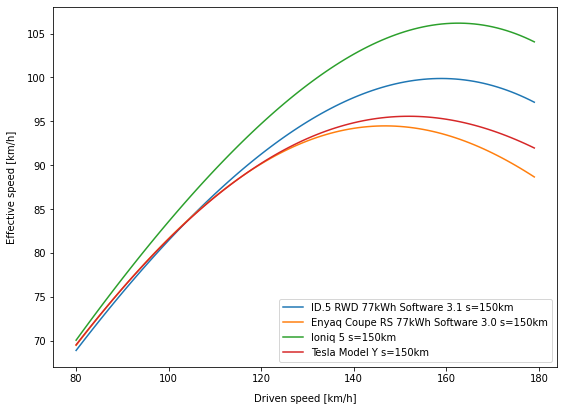

In [357]:
#@title Comparison cars { run: "auto" }
#@markdown The effective speed (including charging stops) as a function of the driven speed.
#@markdown Here the cars are compared with the same fixed stage distance s in [km].
fixed_distance = 150 #@param {type:"slider", min:80, max:300, step:10}

fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

for c in compare_cars:
  c.plot_fixed_distance(fixed_distance, fig)
# Add the x and y-axis labels
ax.set_ylabel('Effective speed [km/h]', labelpad=10)
ax.set_xlabel('Driven speed [km/h]', labelpad=10)
plt.legend()
plt.show()


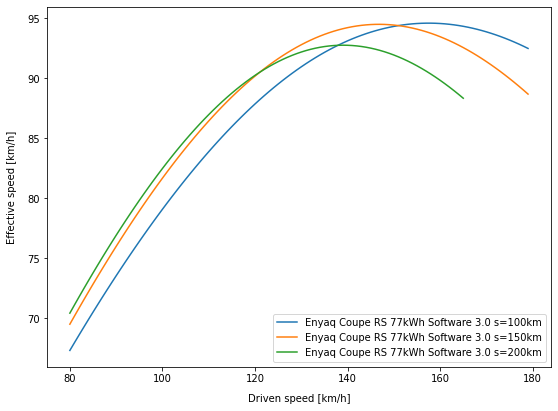

In [358]:
#@title Different stage distance { run: "auto" }
#@markdown The effective speed (including charging stops) as a function of the driven speed.
#@markdown Here the cars are compared with the same fixed stage distance s in [km].
fixed_distance1 = 100 #@param {type:"slider", min:80, max:300, step:10}
fixed_distance2 = 150 #@param {type:"slider", min:80, max:300, step:10}
fixed_distance3 = 200 #@param {type:"slider", min:80, max:300, step:10}
car_number = "Car 5" #@param ["Car 1", "Car 2", "Car 3","Car 4", "Car 5", "Car 6"]

fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
for idx, s in enumerate(["Car 1", "Car 2", "Car 3","Car 4", "Car 5", "Car 6"]):
  if car_number == s:
    cars[idx].plot_fixed_distance(fixed_distance1, fig)
    cars[idx].plot_fixed_distance(fixed_distance2, fig)
    cars[idx].plot_fixed_distance(fixed_distance3, fig)

# Add the x and y-axis labels
ax.set_ylabel('Effective speed [km/h]', labelpad=10)
ax.set_xlabel('Driven speed [km/h]', labelpad=10)
plt.legend()
plt.show()


# Charging curves

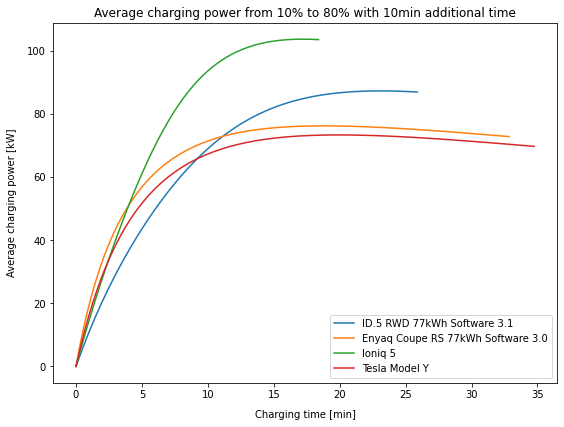

In [362]:
#@title Comparison of charging curves { run: "auto" }
#@markdown The curve represents the average charging power as a function of charging time.
#@markdown The extra_time paramter is taken into account (see settings), and reduces
#@markdown the average charging power.
#@markdown 
#@markdown E_avg = E / (t1+t2)
#@markdown 
#@markdown (Charged energy E; Charging time t1; Extra Time t2) 

fig = plt.figure(figsize=(7, 5))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

for c in compare_cars:
  c.plot_charging_curve(fig=fig)

# Add the x and y-axis labels
plt.title('Average charging power from %2d%% to 80%% with %2dmin additional time'%(start_charging_at, extra_time_per_stop))
ax.set_ylabel('Average charging power [kW]', labelpad=10)
ax.set_xlabel('Charging time [min]', labelpad=10)
plt.legend(loc='lower right')
plt.show()

# Test functions


In [ ]:
#@title Plot data fitting curves as check
#@markdown Show/Plot the fitting curves of the input data to check if the fit is reasonable.
import ipywidgets as widgets
from IPython.display import display
button1 = widgets.Button(description="Show consumption")
output1 = widgets.Output()

button2 = widgets.Button(description="Show charging")
output2 = widgets.Output()

def on_button1_clicked(b):
  with output1:
    for c in cars:
      c.plot_consumption_curve()

def on_button2_clicked(b):
  with output2:
    for c in cars:
      c.plot_charging_time_curve()

button1.on_click(on_button1_clicked)
button2.on_click(on_button2_clicked)
display(button1, output1)
display(button2, output2)